In [1]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete.csv


In [2]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",",parse_dates=['Date'])
df.groupby(['Country/Region']).sum()
a = df['Country/Region']
print(a)
df.groupby(['Confirmed']).sum()

b = df['Confirmed']
print(b)
# date = [elem for elem in df['Date']]
# values = [elem for elem in df['Confirmed']]
# plt.xticks(range(0,len(date)),rotation=45)
# plt.plot(country, values)
df = pd.read_csv("covid_19_clean_complete.csv")
df.tail(5)
c= df['Date']
print(c)


#df['Date'] = pd.to_datetime(df['Date'])
#df['Dates'] = df['Date'].apply(lambda x:x.strftime('%B'))
#p = df.groupby('Dates')
#print(p)

df.head(10)

0                  Afghanistan
1                      Albania
2                      Algeria
3                      Andorra
4                       Angola
                 ...          
32060    Sao Tome and Principe
32061                    Yemen
32062                  Comoros
32063               Tajikistan
32064                  Lesotho
Name: Country/Region, Length: 32065, dtype: object
0           0
1           0
2           0
3           0
4           0
         ... 
32060     251
32061     197
32062      34
32063    2350
32064       1
Name: Confirmed, Length: 32065, dtype: int64
0        1/22/20
1        1/22/20
2        1/22/20
3        1/22/20
4        1/22/20
          ...   
32060    5/21/20
32061    5/21/20
32062    5/21/20
32063    5/21/20
32064    5/21/20
Name: Date, Length: 32065, dtype: object


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0,0
5,NaN,Antigua and Barbuda,17.0608,-61.7964,1/22/20,0,0,0
6,NaN,Argentina,-38.4161,-63.6167,1/22/20,0,0,0
7,NaN,Armenia,40.0691,45.0382,1/22/20,0,0,0
8,Australian Capital Territory,Australia,-35.4735,149.0124,1/22/20,0,0,0
9,New South Wales,Australia,-33.8688,151.2093,1/22/20,0,0,0


In [76]:
sns.set(palette = 'Set1',style='darkgrid')
#Function for making a time serie on a designated country and plotting the rolled mean and standard 
def roll(country,case='Deaths'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Deaths']>=10)])
    ts=ts[-a:]
    return (ts.rolling(window=4,center=False).mean().dropna())


def rollPlot(country, case='Deaths'):
    ts=df.loc[(df['Country/Region']==country)]  
    ts=ts[['Date',case]]
    ts=ts.set_index('Date')
    ts.astype('int64')
    a=len(ts.loc[(ts['Deaths']>=10)])
    ts=ts[-a:]
    plt.figure(figsize=(16,6))
    plt.plot(ts.rolling(window=7,center=False).mean().dropna(),label='Rolling Mean')
    plt.plot(ts[case], label='Deaths')
    plt.plot(ts.rolling(window=7,center=False).std(),label='Rolling std')
    #plt.plot('Confirmed', label='First Line')
    plt.legend()
    plt.title('Cases distribution in %s with rolling mean and standard' %country)
    plt.xticks([])

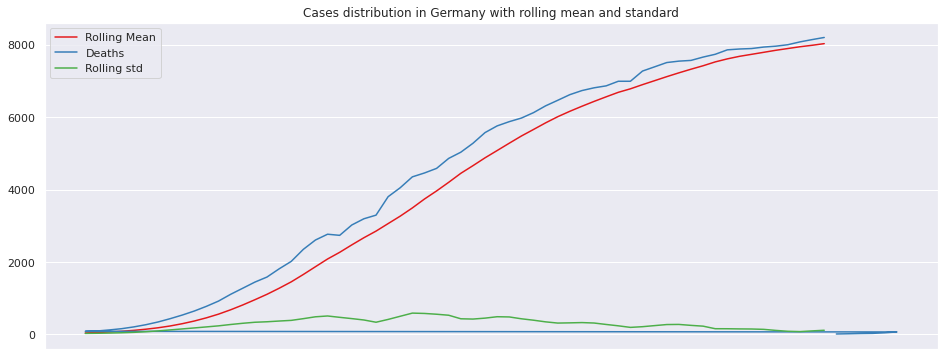

In [77]:
tsC1=roll('Germany')
rollPlot('Germany')

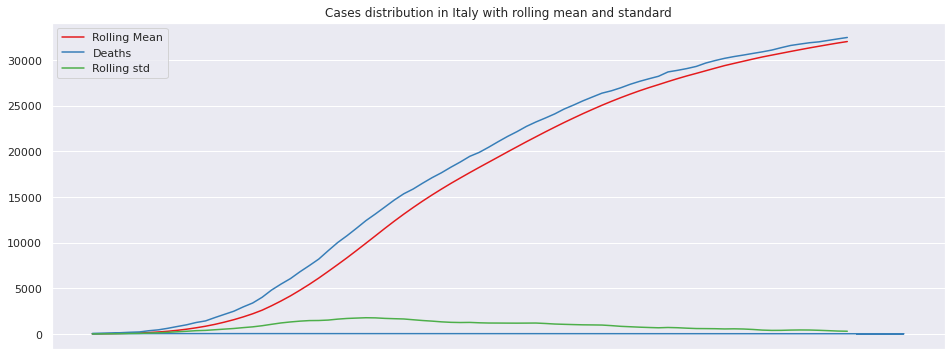

In [78]:
tsC2=roll('Italy')
rollPlot('Italy')

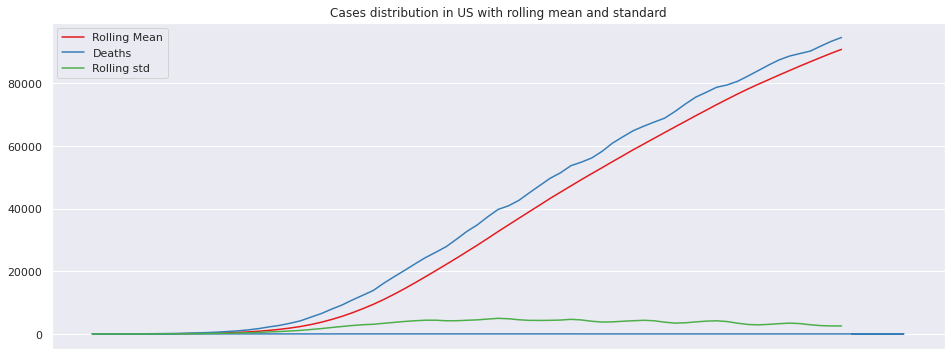

In [79]:
tsC3=roll('US')
rollPlot('US')

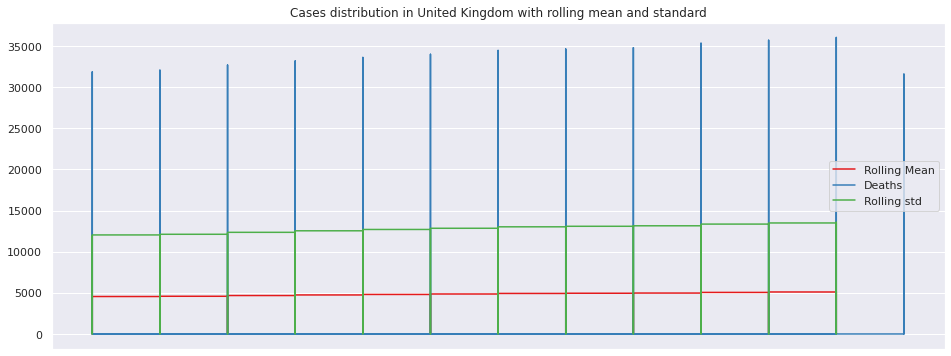

In [80]:
tsC4=roll('United Kingdom')
rollPlot('United Kingdom')

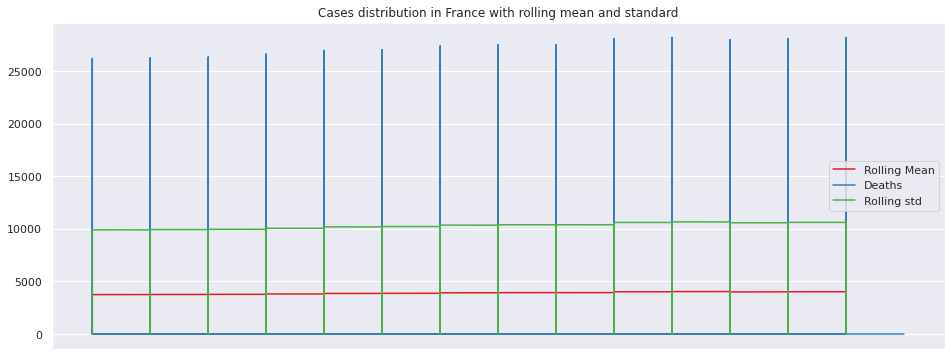

In [81]:
tsC5=roll('France')
rollPlot('France')

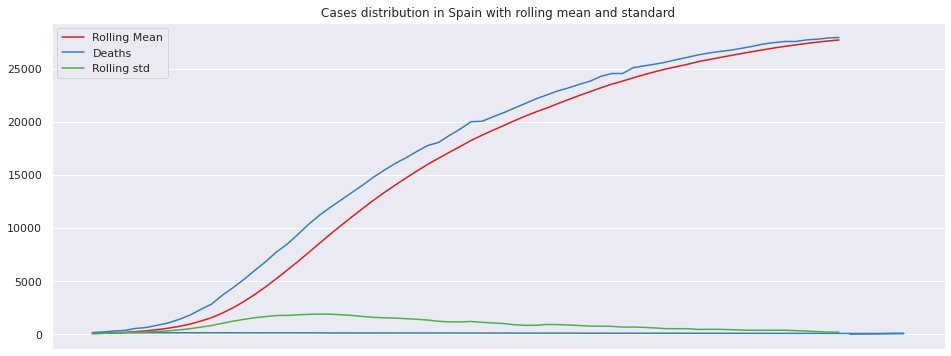

In [82]:
tsC6=roll('Spain')
rollPlot('Spain')

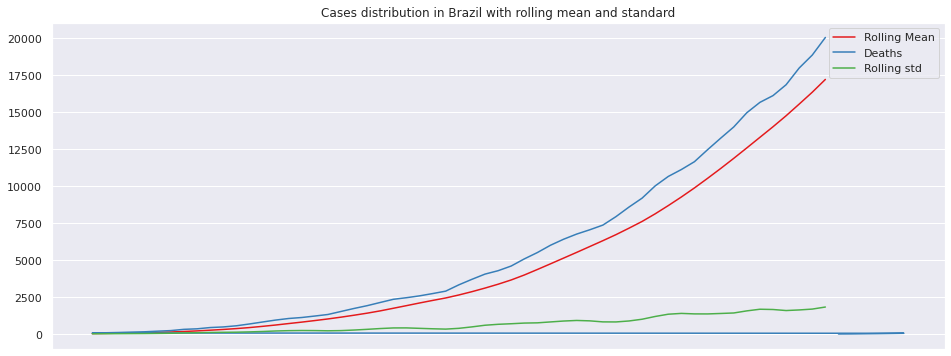

In [83]:
tsC7=roll('Brazil')
rollPlot('Brazil')

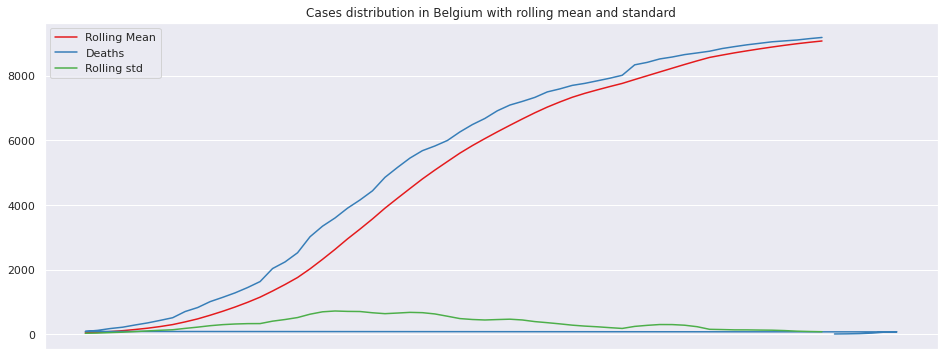

In [84]:
tsC8=roll('Belgium')
rollPlot('Belgium')

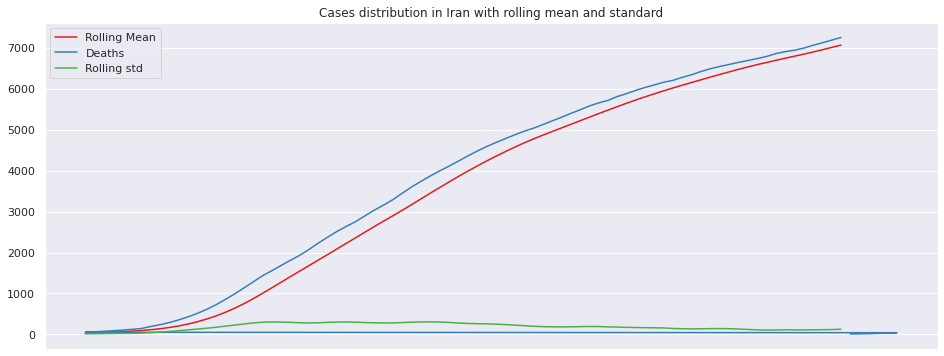

In [85]:
tsC9=roll('Iran')
rollPlot('Iran')

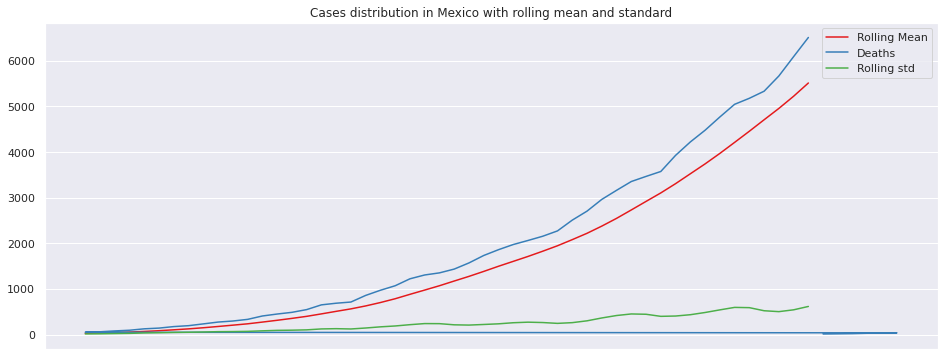

In [86]:
tsC10=roll('Mexico')
rollPlot('Mexico')

In [87]:

df = pd.read_csv("covid_19_clean_complete.csv", delimiter=",")
train_data, test_data= np.split(df, [int(.75 *len(df))])

In [88]:
#test['Date'] = pd.to_datetime(test['Date'])
#train['Date'] = pd.to_datetime(train['Date'])
train_data = train_data.set_index(['Date'])
test_data = test_data.set_index(['Date'])

#data['Date'] = pd.to_datetime(data['Date'])

#data.set_index(['Date', 'month'], inplace=True)

In [89]:
def create_features(df,label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    #df['hour'] = df['Dates'].dt.hour
    df['dayofweek'] = df['Date'].str.replace('dayofweek','')
    #df['quarter'] = df['Dates'].dt.quarter
    df['month'] = df['Date'].str.replace('month','')
    df['year'] = df['Date'].str.replace('year','')
    df['dayofyear'] = df['Date'].str.replace('dayofyear','')
    df['dayofmonth'] = df['Date'].str.replace('dayofmonth','')
    df['weekofyear'] = df['Date'].str.replace('weekofyear','')
    
    X = df[['dayofweek','month','year',
           'dayofyear','dayofmonth','weekofyear']]
   
    return X

In [90]:
train_features=pd.DataFrame(create_features(train_data))
test_features=pd.DataFrame(create_features(test_data))
features_and_target_train = pd.concat([train_data,train_features], axis=1)
features_and_target_test = pd.concat([test_data,test_features], axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def FunLabelEncoder(df):
    for c in df.columns:
        if df.dtypes[c] == object:
            le.fit(df[c].astype(str))
            df[c] = le.transform(df[c].astype(str))
    return df
features_and_target_train= FunLabelEncoder(features_and_target_train)

In [91]:
x_train= features_and_target_train[['Country/Region','month' , 'weekofyear']]
y1 = features_and_target_train[['Deaths']]
x_test = features_and_target_test[['Country/Region', 'month' , 'weekofyear']]

In [92]:
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_squared_error,mean_absolute_error

Predicted values : [7616.64006707 7671.43621551 7761.8633101  7860.8660943  7972.36959755
 8062.7594309  8134.85335376 8202.57606246 8274.24853297 8368.85306069]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   53
Model:                 ARIMA(4, 2, 3)   Log Likelihood                -236.237
Method:                       css-mle   S.D. of innovations             19.515
Date:                Mon, 13 Jul 2020   AIC                            490.474
Time:                        22:02:36   BIC                            508.206
Sample:                    03-20-2020   HQIC                           497.293
                         - 05-11-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2741      2.843 

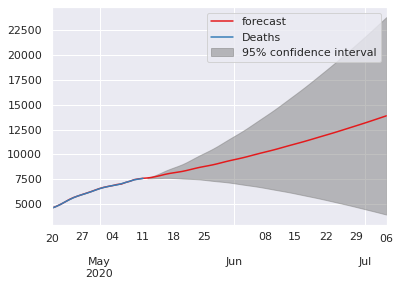

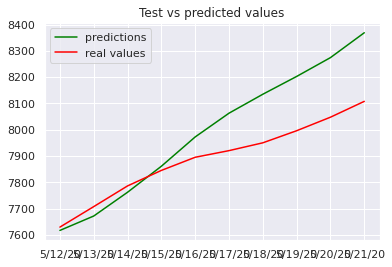

In [94]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC1)
prediction=arima(train,test)

Predicted values : [30820.45454413 30984.61075946 31133.72450405 31266.73734944
 31390.0918283  31507.45857521 31620.75442594 31732.42147048
 31844.99550526]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   73
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -324.432
Method:                       css-mle   S.D. of innovations             18.816
Date:                Mon, 13 Jul 2020   AIC                            672.863
Time:                        22:04:28   BIC                            700.349
Sample:                    03-01-2020   HQIC                           683.817
                         - 05-12-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4806      8.837     

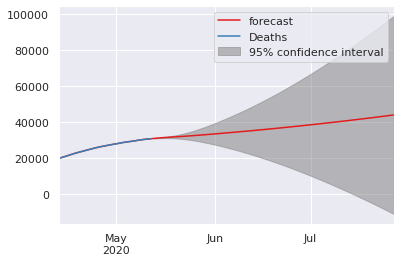

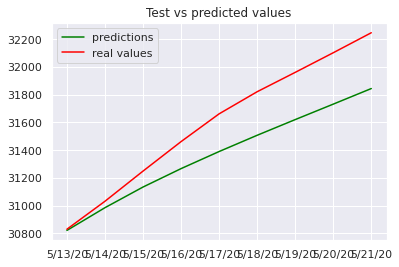

In [96]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.90)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC2)
prediction=arima(train,test)

Predicted values : [83212.32273366 84815.55812248 86212.95721952 87411.53461754
 88399.03874542 89332.58378746 90417.34857195 91618.03292218]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   66
Model:                 ARIMA(5, 2, 1)   Log Likelihood                -383.369
Method:                       css-mle   S.D. of innovations             78.068
Date:                Mon, 13 Jul 2020   AIC                            782.739
Time:                        22:05:16   BIC                            800.256
Sample:                    03-09-2020   HQIC                           789.661
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.9166     38.566      0.076      0.94

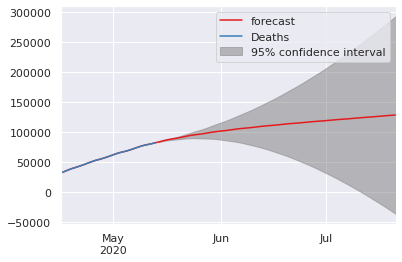

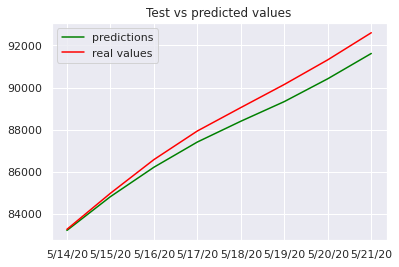

In [97]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.90)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC3)
prediction=arima(train,test)

Predicted values : [8187.79933531 7324.1265901   705.43178012  752.71682215 1307.76078165
 -146.42501714 4425.62172843 4476.57065049 3442.11700932 5876.62230369
 2732.67595405 2382.15915073 3998.93053317 1334.86749775]
                             ARIMA Model Results                              
Dep. Variable:               D.Deaths   No. Observations:                  120
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1092.272
Method:                       css-mle   S.D. of innovations           2044.231
Date:                Mon, 13 Jul 2020   AIC                           2202.544
Time:                        22:05:58   BIC                           2227.631
Sample:                             1   HQIC                          2212.732
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

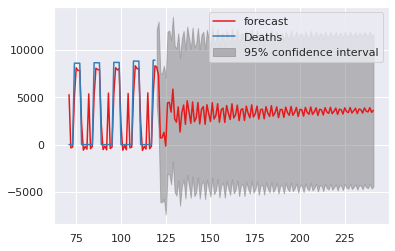

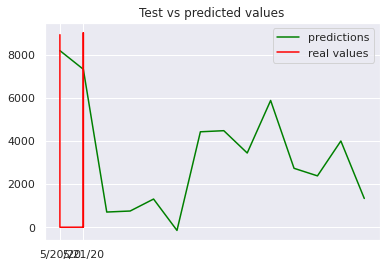

In [98]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.90)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC4)
prediction=arima(train,test)

Predicted values : [ 6246.02065752   638.17056892  -637.59079244 -1310.72639617
 -3021.07874232  1001.31220355  2731.68330969  3723.85254162
  7236.15603314  5326.50630537]
                              ARMA Model Results                              
Dep. Variable:                 Deaths   No. Observations:                  142
Model:                     ARMA(4, 3)   Log Likelihood               -1233.761
Method:                       css-mle   S.D. of innovations           1371.025
Date:                Mon, 13 Jul 2020   AIC                           2485.522
Time:                        22:06:36   BIC                           2512.125
Sample:                             0   HQIC                          2496.333
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2473.3415     24.18

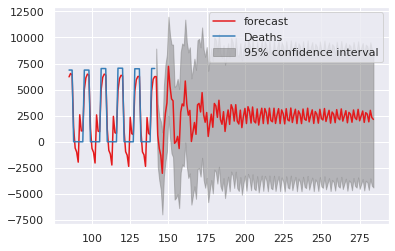

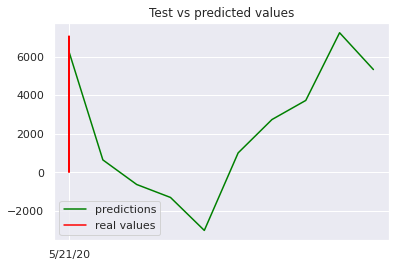

In [99]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.94)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC5)
prediction=arima(train,test)

Predicted values : [26570.22956214 26750.68452121 26918.49958915 27098.37436557
 27278.07971015 27452.04530828 27631.81249619 27816.2530964
 27999.78105816 28186.03466286 28376.76816215]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   60
Model:                 ARIMA(3, 2, 2)   Log Likelihood                -303.691
Method:                       css-mle   S.D. of innovations             37.379
Date:                Mon, 13 Jul 2020   AIC                            621.382
Time:                        22:09:16   BIC                            636.043
Sample:                    03-12-2020   HQIC                           627.117
                         - 05-10-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const        

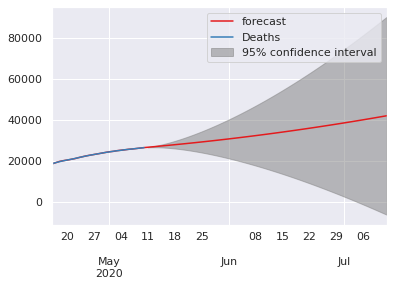

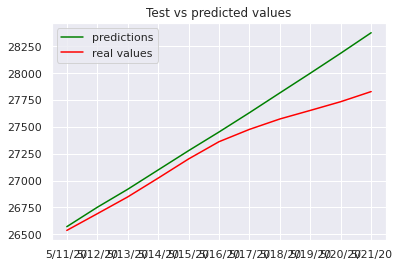

In [102]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC6)
prediction=arima(train,test)

Predicted values : [12794.44821668 13506.11348669 14233.0922617  14961.86930794
 15692.56971785 16423.74105766 17171.18828988 17937.98426552]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   50
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -224.178
Method:                       css-mle   S.D. of innovations             20.345
Date:                Mon, 13 Jul 2020   AIC                            462.357
Time:                        22:10:38   BIC                            475.741
Sample:                    03-25-2020   HQIC                           467.453
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              13.4195      3.158      4.250      0.00

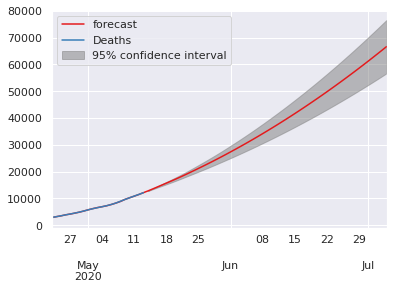

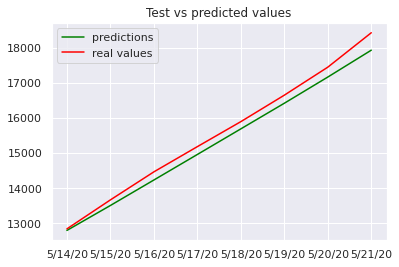

In [103]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.88)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC7)
prediction=arima(train,test)

Predicted values : [8683.2389905  8758.79620433 8838.42580055 8919.89207412 9002.65633716
 9086.71858969 9172.0788317  9258.73706319 9346.69328416 9435.94749461]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   51
Model:                 ARIMA(0, 2, 4)   Log Likelihood                -226.329
Method:                       css-mle   S.D. of innovations             18.884
Date:                Mon, 13 Jul 2020   AIC                            464.658
Time:                        22:12:07   BIC                            476.249
Sample:                    03-22-2020   HQIC                           469.087
                         - 05-11-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2980      4.891 

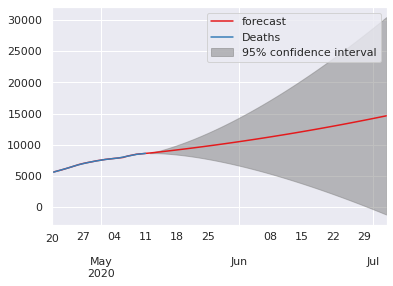

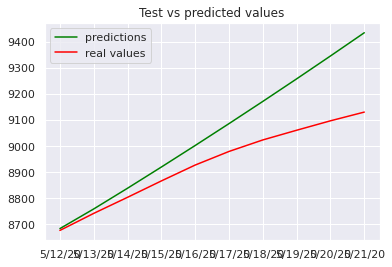

In [105]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC8)
prediction=arima(train,test)

Predicted values : [6511.92609391 6573.37519517 6632.62883165 6692.63006929 6753.3789081
 6814.87534808 6877.11938922 6940.11103153 7003.850275   7068.33711964
 7133.57156545 7199.55361242 7266.28326056]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   70
Model:                 ARIMA(0, 2, 3)   Log Likelihood                -181.298
Method:                       css-mle   S.D. of innovations              3.002
Date:                Mon, 13 Jul 2020   AIC                            372.597
Time:                        22:13:11   BIC                            383.839
Sample:                    02-29-2020   HQIC                           377.062
                         - 05-08-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------

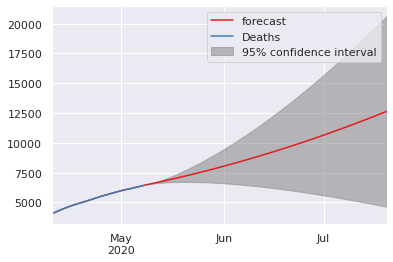

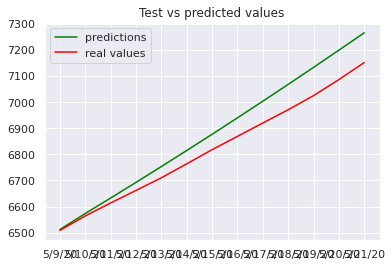

In [107]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC9)
prediction=arima(train,test)

Predicted values : [4036.72218343 4296.25920618 4534.33167001 4756.72254277 4974.21536906
 5198.37894793 5449.47835417 5720.9548924 ]
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                   43
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -166.092
Method:                       css-mle   S.D. of innovations             11.201
Date:                Mon, 13 Jul 2020   AIC                            344.184
Time:                        22:13:43   BIC                            354.751
Sample:                    04-01-2020   HQIC                           348.081
                         - 05-13-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.0211      0.929      5.406      0.000       

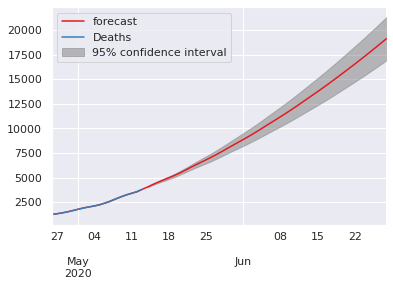

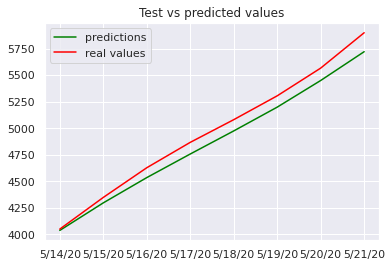

In [108]:

#Mean absolute percentage error
def mape(y1, y_pred): 
    y1, y_pred = np.array(y1), np.array(y_pred)
    return np.mean(np.abs((y1 - y_pred) / y1)) * 100

def split(ts):
    #splitting 85%/15% because of little amount of data
    size = int(len(ts) * 0.85)
    train= ts[:size]
    test = ts[size:]
    return(train,test)


#Arima modeling for ts
def arima(ts,test):
    p=d=q=range(0,6)
    a=99999
    pdq=list(itertools.product(p,d,q))
    
    #Determining the best parameters
    for var in pdq:
        try:
            model = ARIMA(ts, order=var)
            result = model.fit()

            if (result.aic<=a) :
                a=result.aic
                param=var
        except:
            continue
            
    #Modeling
    model = ARIMA(ts, order=param)
    result = model.fit()
    result.plot_predict(start=int(len(ts) * 0.6), end=int(len(ts) * 2.0))
    prediction=result.forecast(steps=len(test))[0]
    
    #Plotting results
    f,ax=plt.subplots()
    plt.plot(prediction,c='green', label= 'predictions')
    plt.plot(test, c='red',label='real values')
    plt.legend()
    plt.title('Test vs predicted values')

    #printing prediction values
    print('Predicted values :',prediction)
    #Printing the error metrics
    print(result.summary())        
    
    
    print('Error Values')
    print('Mean Value :', test.mean())
    print('MAE Value :', meanabs(test,prediction))
    print('RMSE Value :', np.sqrt(mean_squared_error(test,prediction)))
    print('\nMean absolute percentage error: %f'%mape(test,prediction))
    return (prediction)



train,test=split(tsC10)
prediction=arima(train,test)

In [ ]:
#Checking for similarity(Trend) between Germany and Italy in Death cases using number of predicted values from model result

In [ ]:

from scipy.special import rel_entr
# defining distributions
Germany = [7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069]
Italy = [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576]
# calculating (Germany || Italy)
kl_Germany_Italy = rel_entr(Germany, Italy)
print('KL(Germany || Italy): %.3f nats' % sum(kl_Germany_Italy))
# calculating (Italy || Germany)
kl_Italy_Germany = rel_entr(Italy,Germany)
print('KL(Italy || Germany): %.3f nats' % sum(kl_Italy_Germany))

KL(Germany || Italy): -67479.016 nats
KL(Italy || Germany): 267337.231 nats


In [ ]:
#Hence,Kl divergence satisfies the condition that KL(Germany || Italy)!=KL(Italy || Germany)


In [ ]:

from scipy.spatial.distance import jensenshannon
from numpy import asarray
# defining distributions
Germany = asarray([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069])
Italy = asarray([31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])
# calculating (Germany || Italy)
JS_Germany_Italy = jensenshannon(Germany, Italy,base=2)
print('JS(Germany || Italy): %.3f nats' % JS_Germany_Italy)
# calculating (Italy || Germany)
JS_Italy_Germany = jensenshannon(Italy,Germany,base=2)
print('JS(Italy || Germany): %.3f nats' % JS_Italy_Germany)

JS(Germany || Italy): 0.001 nats
JS(Italy || Germany): 0.001 nats


In [ ]:
#Hence,JS divergence satisfies the condition that JS(Germany || Italy)==JS(Italy || Germany)


In [ ]:
from scipy import stats
stats.spearmanr([7972.36959755, 8062.7594309,  8134.85335376, 8202.57606246, 8274.24853297, 8368.85306069], [31473.31708024, 31824.28657176, 32179.43901308, 32538.77440418,
 32902.29274508, 33269.99403576])

np.random.seed(7972)
x2n = np.random.randn(100, 2)
y2n = np.random.randn(100, 2)
stats.spearmanr(x2n)

SpearmanrResult(correlation=0.1438943894389439, pvalue=0.15320623761722527)

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943
#df.loc[(df['Country/Region']==country)]
r, p = stats.pearsonr(df.loc[(Country/Region['Germany'])].dropna(), df.loc[(df['Country/Region(Italy)'])].dropna())
#r, p = stats.pearsonr(df.dropna()['Confirmed'], df.dropna()['Recovered'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
# out: Scipy computed Pearson r: 0.20587745135619354 and p-value: 3.7902989479463397e-51

# Compute rolling window synchrony
f,ax=plt.subplots(figsize=(7,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(overall_pearson_r,2)}");

Pandas computed Pearson r: -0.1282098089914872


NameError: ignored